<a href="https://colab.research.google.com/github/RamaKrisnakommineni/INFO7374/blob/master/Assignment2/Part%202/A2Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, zipfile, io, requests
URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
def download_images(url):
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()
download_images(URL) #To download

In [0]:
import numpy as np
from PIL import Image
import six.moves.cPickle as pickle

data = {}
data['train'] = {}
data['test'] = {}
data['train']['data'] = []
data['train']['target'] = []
data['test']['data'] = []
data['test']['target'] = []
size = (32, 32)
N = 400 ##400 as testing and 100 as training in each class

wnids = list(map(lambda x: x.strip(), open('tiny-imagenet-200/wnids.txt').readlines()))

for i in range(len(wnids)):
    wnid = wnids[i]
    print ("{}: {} / {}".format(wnid, i + 1, len(wnids)))
    for j in range(500):
        path = "tiny-imagenet-200/train/{0}/images/{0}_{1}.JPEG".format(wnid, j)
        image = (Image.open(path).convert('RGB'))
        image = image.resize(size, Image.ANTIALIAS)
        image = np.array(image)
        if j < N:
            data['train']['data'].append(image)
            data['train']['target'].append(i)
        else:
            data['test']['data'].append(image)
            data['test']['target'].append(i)
            

print ("Dump to train.pkl...")
pickle.dump(data, open('train.pkl', 'wb', -1))

n07715103: 199 / 200
n02504458: 200 / 200
Dump to train.pkl...


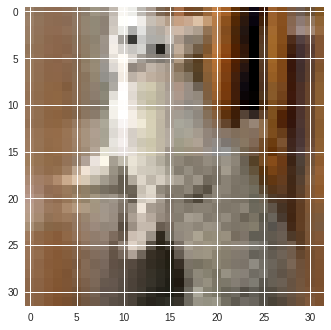

2


In [0]:
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
data=pickle.load(open("train.pkl",'rb'))
#data['train']['data'][750]
plt.imshow(data['train']['data'][50])
plt.show()
print(data['train']['target'][950])

Experiment 1

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import TensorBoard, EarlyStopping
from time import time

(x_train, y_train), (x_test, y_test) = (data['train']['data'],data['train']['target']),(data['test']['data'],data['test']['target'])

num_classes=200


x_train = np.array(x_train)
x_test = np.array(x_test)
x_train =x_train/ 255
x_test = x_test/255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [0]:


opts = [('SGD', SGD()), ('Adagrad', Adagrad()), ('Adadelta', Adadelta()), 
        ('Adam', Adam()), ('Adamax', Adamax())]


batch_size = 32
epochs = 50
data_augmentation = True

save_dir = os.path.join(os.getcwd(), 'saved_models')

Accuracy_list = []
for name,opt in opts:
    print('Training ' + name + ' optimizer')
    logs = "logs/optimizer/"+name
    
    model_name = name + 'Optmizer for TinyImagenet200'

  # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    start = time()
  
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history=model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            steps_per_epoch=500)

    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)

    end = time()

    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    print('Time taken to compile:', str(end-start))
    Accuracy_list.append([name,scores[1]])


Training SGD optimizer
Using real-time data augmentation.
Epoch 1/50
500/500 [==============================] - 16s 32ms/step - loss: 5.2983 - acc: 0.0048 - val_loss: 5.2972 - val_acc: 0.0049
Epoch 2/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2975 - acc: 0.0057 - val_loss: 5.2963 - val_acc: 0.0062
Epoch 3/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2958 - acc: 0.0062 - val_loss: 5.2931 - val_acc: 0.0092
Epoch 4/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2906 - acc: 0.0073 - val_loss: 5.2819 - val_acc: 0.0092
Epoch 5/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2765 - acc: 0.0090 - val_loss: 5.2449 - val_acc: 0.0097
Epoch 6/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2344 - acc: 0.0112 - val_loss: 5.1902 - val_acc: 0.0100
Epoch 7/50
500/500 [==============================] - 15s 29ms/step - loss: 5.2066 - acc: 0.0094 - val_loss: 5.1600 - val_acc: 0.0109
Epoc

In [0]:
Accuracy_list

[['SGD', 0.1036],
 ['Adagrad', 0.2138],
 ['Adadelta', 0.22385],
 ['Adam', 0.236],
 ['Adamax', 0.2711]]

Adamax optimizer got the maximum accuracy,
**Now with Adamax optimizer we shall change activation functions**

In [0]:
activations = ['tanh','relu','elu']

save_dir = os.path.join(os.getcwd(), 'saved_models')
Activation_accuracy=[]
batch_size = 32
epochs = 50
data_augmentation = True
for acti in activations:
  print('Training with' + acti + ' Activation function')
  logs = "logs/optimizer/"+name
    
  model_name = acti + 'Activation for TinyImagenet200'
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation(acti))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation(acti))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation(acti))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation(acti))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(acti))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer

  model.summary()
  
  model.compile(loss='categorical_crossentropy',optimizer=Adamax(),metrics=['accuracy'])

  start = time()
  
  if not data_augmentation:
      print('Not using data augmentation.')
      model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
  else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history=model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            steps_per_epoch=500)

    # Save model and weights
  if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        model_path = os.path.join(save_dir, model_name)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

    # Score trained model.
  scores = model.evaluate(x_test, y_test, verbose=1)

  end = time()

  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  print('Time taken to compile:', str(end-start))
  Activation_accuracy.append([acti,scores[1]])
  

Training withtanh Activation function
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15

In [0]:
Activation_accuracy

[['tanh', 0.1809], ['relu', 0.2227], ['elu', 0.1914]]

Accuracy was high when relu activation function is used
**Next we shall change the number of epochs keeping Adamax optimizer and relu activation**

In [0]:
epochs = [75,100]

save_dir = os.path.join(os.getcwd(), 'saved_models')
Epoch_accuracy=[]
batch_size = 32
data_augmentation = True
for ep in epochs:
  epochs = ep
  print('Training with ' + str(ep) + ' epochs')
  logs = "logs/optimizer/"+str(ep)
    
  model_name = str(ep) + 'epochs for TinyImagenet200'
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  # initiate RMSprop optimizer

  model.summary()
  
  model.compile(loss='categorical_crossentropy',optimizer=Adamax(),metrics=['accuracy'])

  start = time()
  
  if not data_augmentation:
      print('Not using data augmentation.')
      model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
  else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history=model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            steps_per_epoch=500)

    # Save model and weights
  if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)

    # Score trained model.
  scores = model.evaluate(x_test, y_test, verbose=1)

  end = time()

  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  print('Time taken to compile:', str(end-start))
  Epoch_accuracy.append([ep,scores[1]])
  


Training with 75 epochs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)     

In [0]:
Epoch_accuracy

[[75, 0.2596], [100, 0.2711]]